In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import json

In [3]:
working_dir = os.getcwd()
print(f"You are now working in {working_dir}")
print("If you need to change to the parent directory, run the cell below")

You are now working in c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN\jupyter_notebooks
If you need to change to the parent directory, run the cell below


In [4]:
os.chdir(os.path.dirname(working_dir))
new_working_dir = os.getcwd()
print(f"You have now changed your working directory to {new_working_dir}")

You have now changed your working directory to c:\Users\fredd\Desktop\Studier\Project5\flowers\flowers_CNN


In [5]:
version = 'v1'
file_path = f'outputs/{version}'
current_working_dir = os.getcwd()

if 'outputs' in os.listdir(current_working_dir) and version in os.listdir(current_working_dir + '/outputs'):
    print("This version already exists, create a new version if you are working on a new version")
    pass
else:
    os.makedirs(name=file_path)

This version already exists, create a new version if you are working on a new version


In [10]:
image_dirs = 'inputs/dataset/raw/flower_photos'
train_path = image_dirs + '/train'
val_path = image_dirs + '/validation'
test_path = image_dirs + '/test'

In [11]:
labels = os.listdir(train_path)

print(f"Flower labels: {labels}")

Flower labels: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:


class ImageClassificationPipeline:
    def __init__(self, train_path, val_path, test_path, input_shape=(224, 224, 3), batch_size=20, num_classes=5):
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes

        # Initialize ImageDataGenerators
        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=20,
            width_shift_range=0.10,
            height_shift_range=0.10,
            shear_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )
        self.val_test_datagen = ImageDataGenerator(rescale=1./255)

        # Build data generators
        self.train_set = self.train_datagen.flow_from_directory(
            self.train_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=True
        )
        self.validation_set = self.val_test_datagen.flow_from_directory(
            self.val_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        self.test_set = self.val_test_datagen.flow_from_directory(
            self.test_path, target_size=self.input_shape[:2], batch_size=self.batch_size,
            class_mode='categorical', shuffle=False
        )
        
        # Retrieve label map
        self.label_map = list(self.train_set.class_indices.keys())
        
        # Build model
        self.model = self.build_model()

    def build_model(self):
        model = Sequential([
            Conv2D(32, (3, 3), activation='relu', input_shape=self.input_shape),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(64, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Conv2D(128, (3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Flatten(),
            Dense(128, activation='relu'),
            Dropout(0.5),
            Dense(self.num_classes, activation='softmax')
        ])
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def train(self, epochs=25, early_stopping_patience=3):
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
        
        self.history = self.model.fit(
            self.train_set,
            validation_data=self.validation_set,
            epochs=epochs,
            callbacks=[early_stop],
            verbose=1
        )

    def evaluate(self, savepath=None,  cm_image_path=None): 
        y_pred_probs = self.model.predict(self.test_set)
        y_pred = np.argmax(y_pred_probs, axis=1)
        y_true = self.test_set.classes

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"F1 Score (weighted): {f1:.4f}")

        # Classification report
        report = classification_report(y_true, y_pred, target_names=self.label_map, output_dict=True)
        print("\nClassification Report:")
        print(report)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_map)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        if cm_image_path:
            disp.plot(cmap=plt.cm.Blues)
            plt.savefig(cm_image_path, bbox_inches='tight', dpi=150)
            print(f"Confusion matrix image saved as {cm_image_path}")
        
        # If savepath is given, save JSON-file
        if savepath:
            evaluation_data = {
                "f1_score_weighted": f1,
                "classification_report": report,
                "confussion_matrix": cm.tolist()  # Converts numpy array to list for JSON-file
            }

            # Saves data as JSON-file
            with open(savepath, 'w') as f:
                json.dump(evaluation_data, f, indent=4)
            print(f"Evaluation saved as {savepath}")

    def plot_training_history(self, savepath):
        plt.figure(figsize=(12, 5))
        
        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Train Accuracy')
        plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Train Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig(savepath, bbox_inches='tight', dpi=150)
        plt.show()


    def save_model(self, filepath):
        self.model.save(filepath)
        print(f"Model saved as {filepath}")
        
    def model_summary(self):
        self.model.summary()

In [ ]:
pipeline = ImageClassificationPipeline(train_path, val_path, test_path)
pipeline.train(epochs=25)
pipeline.save_model("flower_prediction_model.h5")


Found 20549 images belonging to 5 classes.
Found 2934 images belonging to 5 classes.
Found 5877 images belonging to 5 classes.


C:\Users\fredd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\fredd\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 591s 573ms/step - accuracy: 0.4300 - loss: 1.3480 - val_accuracy: 0.6411 - val_loss: 0.8989
Epoch 2/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 574s 558ms/step - accuracy: 0.6540 - loss: 0.9084 - val_accuracy: 0.6926 - val_loss: 0.7812
Epoch 3/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 574s 558ms/step - accuracy: 0.6841 - loss: 0.8199 - val_accuracy: 0.7157 - val_loss: 0.7355
Epoch 4/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 573s 557ms/step - accuracy: 0.7172 - loss: 0.7451 - val_accuracy: 0.7277 - val_loss: 0.6554
Epoch 5/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 573s 558ms/step - accuracy: 0.7392 - loss: 0.6981 - val_accuracy: 0.7682 - val_loss: 0.6032
Epoch 6/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 574s 558ms/step - accuracy: 0.7458 - loss: 0.6708 - val_accuracy: 0.7672 - val_loss: 0.5848
Epoch 7/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 573s 558ms/step - accuracy: 0.7565 - loss: 0.6331 - val_accuracy: 0.7829 - val_loss: 0.5336
Epoch 8/25
1028/1028 ━━━━━━━━━━━━━━━━━━━━ 574s 558ms/step - ac

294/294 ━━━━━━━━━━━━━━━━━━━━ 39s 131ms/step
F1 Score (weighted): 0.8631

Classification Report:
{'daisy': {'precision': 0.947603121516165, 'recall': 0.8382642998027613, 'f1-score': 0.8895866038723181, 'support': 1014.0}, 'dandelion': {'precision': 0.9083275017494752, 'recall': 0.9026425591098748, 'f1-score': 0.9054761074293687, 'support': 1438.0}, 'roses': {'precision': 0.7685714285714286, 'recall': 0.7857838364167478, 'f1-score': 0.7770823302840636, 'support': 1027.0}, 'sunflowers': {'precision': 0.8879668049792531, 'recall': 0.9562109025915997, 'f1-score': 0.9208261617900172, 'support': 1119.0}, 'tulips': {'precision': 0.8078703703703703, 'recall': 0.818608287724785, 'f1-score': 0.8132038834951456, 'support': 1279.0}, 'accuracy': 0.8630253530712949, 'macro avg': {'precision': 0.8640678454373385, 'recall': 0.8603019771291537, 'f1-score': 0.8612350173741827, 'support': 5877.0}, 'weighted avg': {'precision': 0.8649427307046932, 'recall': 0.8630253530712949, 'f1-score': 0.863139570196531

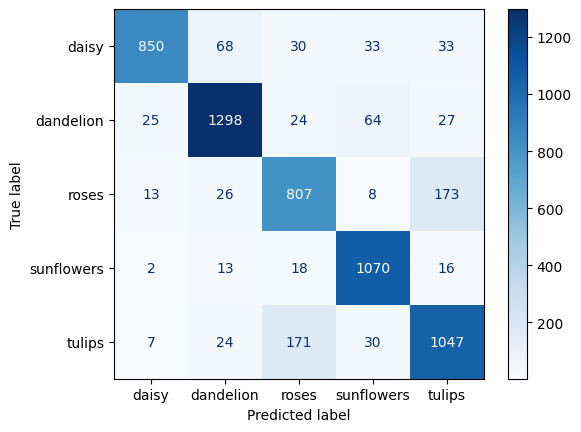

Evaluation saved as outputs/v1/model_evaluation.json


In [ ]:
pipeline.evaluate(savepath=f"{file_path}/model_evaluation.json", cm_image_path=f"{file_path}/confusion_matrix.png")
pipeline.model_summary()

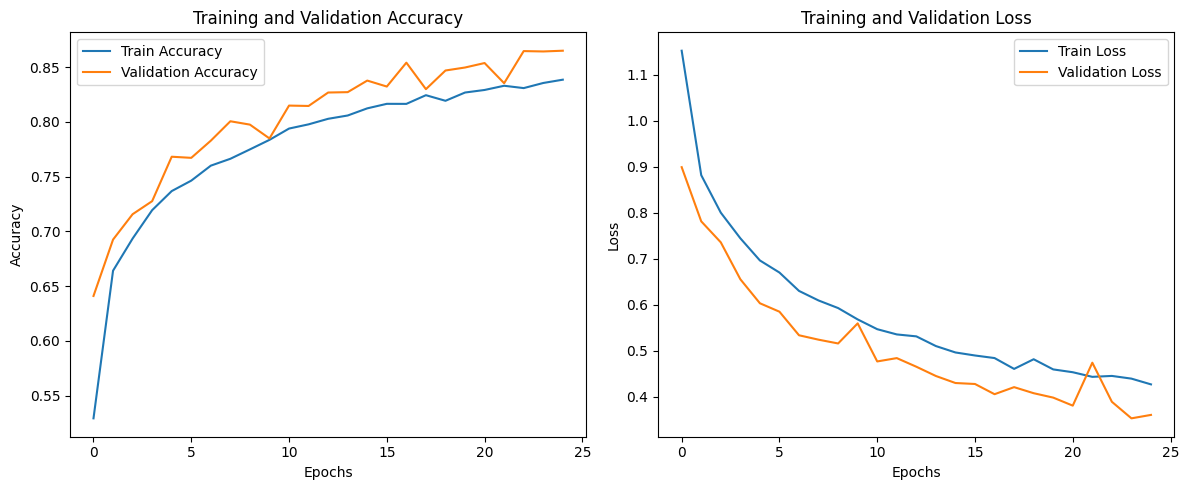

In [15]:
pipeline.plot_training_history(savepath=f"{file_path}/training_history.png")

In [ ]:
json_file = f"{file_path}/model_evaluation.json"

with open(json_file, 'r') as f:
    evaluation_data = json.load(f)
    
print(f"Weighted F1 Score: {evaluation_data['f1_score_weighted']:.4}\n")


# Transforms the JSON-file to a more readable DataFrame
classification_report_df = pd.DataFrame(evaluation_data['classification_report']).transpose()
classification_report_df = classification_report_df.round(4)

classification_report_df = pd.concat([
    classification_report_df.iloc[:-3],  
    pd.DataFrame([[''] * len(classification_report_df.columns)], columns=classification_report_df.columns),  
    classification_report_df.iloc[-3:]  
]).reset_index()

classification_report_df.index.name = None

pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.width', 100)

print("Classification Report:\n", classification_report_df.to_string(index=False))

# Creates a DataFrame for the confussion matrix
labels = list(evaluation_data['classification_report'].keys())[:-3] # Excludes the last 3 labels
confussion_matrix_df = pd.DataFrame(
    evaluation_data['confusion_matrix'],
    index = labels,
    columns = labels
)

print("\nConfussion Matrix:\n", confussion_matrix_df)



Weighted F1 Score: 0.8631

Classification Report:
    index     precision  recall f1-score support
       daisy   0.9476   0.8383  0.8896   1014.0
   dandelion   0.9083   0.9026  0.9055   1438.0
       roses   0.7686   0.7858  0.7771   1027.0
  sunflowers    0.888   0.9562  0.9208   1119.0
      tulips   0.8079   0.8186  0.8132   1279.0
           0                                   
    accuracy    0.863    0.863   0.863    0.863
   macro avg   0.8641   0.8603  0.8612   5877.0
weighted avg   0.8649    0.863  0.8631   5877.0

Confussion Matrix:
             daisy  dandelion  roses  sunflowers  tulips
daisy        850       68       30        33        33 
dandelion     25     1298       24        64        27 
roses         13       26      807         8       173 
sunflowers     2       13       18      1070        16 
tulips         7       24      171        30      1047 
